In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score

from matplotlib import pyplot as plt

## Data Processing
The last line here causes you to test on imbalanced data

In [2]:
df = pd.read_csv("../data/data.csv")
df = df[df["RoleName"] != "Mentor"]

In [3]:
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(df[["content"]], df["OutcomeScore"])
x_train, x_test, y_train, y_test = train_test_split(x_resampled["content"], y_resampled, train_size=0.8, random_state=0)
_, x_test, _, y_test = train_test_split(df["content"], df["OutcomeScore"], train_size=0.8, random_state=0)

## Model Training

In [4]:
text_clf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=0))
text_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

## Evaluation

In [5]:
predictions = text_clf.predict(x_test)

In [6]:
f1_score(y_test, predictions, average="weighted")

0.8373794281635332

In [7]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       105
           1       0.78      0.88      0.83       214
           2       0.92      0.79      0.85       485
           3       0.87      0.83      0.85       474
           4       0.94      0.77      0.85      1236
           5       0.85      0.82      0.83       468
           6       0.81      0.87      0.84       297
           7       0.65      0.93      0.76        86
           8       0.07      1.00      0.13        16

    accuracy                           0.81      3381
   macro avg       0.74      0.86      0.75      3381
weighted avg       0.88      0.81      0.84      3381



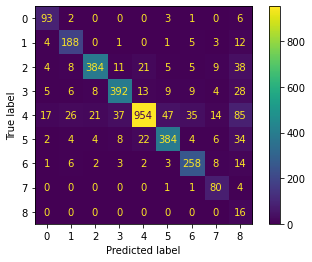

In [8]:
plot_confusion_matrix(text_clf, x_test, y_test);